In [1]:
import os
import re
from glob import glob
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from torchmetrics.classification import MulticlassMatthewsCorrCoef
import open3d as o3

from open3d.web_visualizer import draw # for non Colab

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [2]:
# TEMP for supressing pytorch user warnings
import warnings
warnings.filterwarnings("ignore")

In [1]:
# General parameters
NUM_TRAIN_POINTS = 3500
NUM_TEST_POINTS = 12000
NUM_CLASSES = 16
ROOT = os.getcwd() + r"\archive\shapenet\shapenetcore_partanno_segmentation_benchmark_v0"

# model hyperparameters
GLOBAL_FEATS = 1024
BATCH_SIZE = 64

NameError: name 'os' is not defined

In [48]:

from torch.utils.data import DataLoader
from shapenet_dataset import ShapenetDataset, CATEGORIES, read_pointnet_colors

# train Dataset & DataLoader
train_dataset = ShapenetDataset(ROOT, split='train', npoints=NUM_TRAIN_POINTS, classification=True)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

valid_dataset = ShapenetDataset(ROOT, split='valid', npoints=NUM_TRAIN_POINTS, classification=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)

test_dataset = ShapenetDataset(ROOT, split='test', npoints=NUM_TEST_POINTS, classification=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# test DataSet 

In [90]:
import pointNetModel
sample_dataset = ShapenetDataset(ROOT, npoints=NUM_TRAIN_POINTS, split='train', classification=False, normalize=False)
pointNetModel.show_3d_visualization(sample_dataset=sample_dataset[1045])


In [50]:
total_train_targets = [targets.reshape(-1).numpy().tolist() for (_, targets) in train_dataloader]

# for i in range (len(total_train_targets)):
#     if len(total_train_targets[i]) != 32: 
#         print(i)

total_train_targets = np.array(total_train_targets[:-1]) # ignore the last element


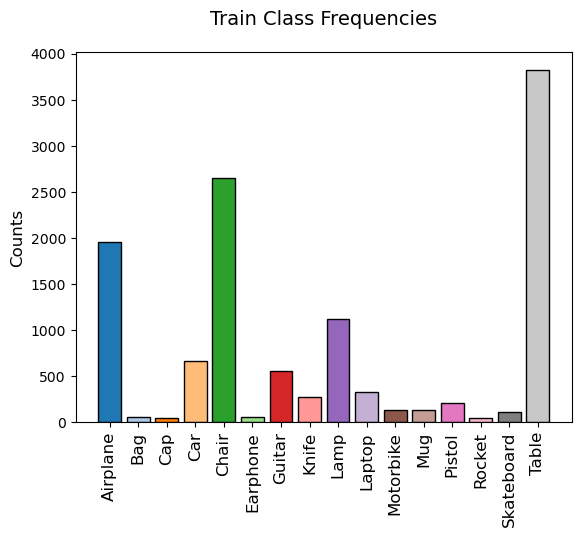

In [51]:
class_bins = np.bincount(total_train_targets.ravel()) #
plt.bar(list(CATEGORIES.keys()), class_bins, 
             color=mpl.cm.tab20(np.arange(0, NUM_CLASSES)),
             edgecolor='black')
plt.xticks(list(CATEGORIES.keys()), list(CATEGORIES.keys()), size=12, rotation=90)
plt.ylabel('Counts', size=12)
plt.title('Train Class Frequencies', size=14, pad=20);

In [52]:
points, targets = next(iter(train_dataloader))
classifier = pointNetModel.PointNetClassHead(k=NUM_CLASSES, num_global_feats=GLOBAL_FEATS)
out, _, _ = classifier(points.transpose(2, 1))
print(f'Class output shape: {out.shape}')

Class output shape: torch.Size([64, 16])


In [53]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [54]:
import torch.optim as optim
from point_net_loss import PointNetLoss

EPOCHS = 50
LR = 0.0001
REG_WEIGHT = 0.001 

# use inverse class weighting
# alpha = 1 / class_bins
# alpha = (alpha/alpha.max())

# manually downweight the high frequency classes
alpha = np.ones(NUM_CLASSES)
alpha[0] = 0.5  # airplane
alpha[4] = 0.5  # chair
alpha[-1] = 0.5 # table

gamma = 2

optimizer = optim.Adam(classifier.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, 
                                              step_size_up=2000, cycle_momentum=False)
criterion = PointNetLoss(alpha=alpha, gamma=gamma, reg_weight=REG_WEIGHT).to(DEVICE)

classifier = classifier.to(DEVICE)

In [55]:
# We want to be sure we are not misclassifying or only focusing on easy or abundant examples. 
# So we use the Matthews Correlation Coefficient to measure our models performance.
mcc_metric = MulticlassMatthewsCorrCoef(num_classes=NUM_CLASSES).to(DEVICE)

In [56]:
def train_test(classifier, dataloader, num_batch, epoch, split="train"):
    "Func to train or test the model"
    _loss = []
    _accurancy = []
    _mcc = []
    
    #return total targets and predictions for test case only
    total_test_targets = []
    total_test_preds = []
    for i, (points, targets) in enumerate(dataloader, 0):
        points = points.transpose(2, 1).to(DEVICE)
        targets = targets.squeeze().to(DEVICE)
        
        #zero gradients
        optimizer.zero_grad()
        
        # get predicted class logits
        preds, _, A = classifier(points)
        
        # get loss and perform backprop
        loss = criterion(preds, targets, A)
        if split == 'train':
            loss.backward()
            optimizer.step()
            scheduler.step()
        
        # get class predictions
        pred_choice = torch.softmax(preds, dim=1).argmax(dim=1)
        correct = pred_choice.eq(targets.data).cpu().sum()
        accuracy = correct.item()/float(BATCH_SIZE)
        mcc = mcc_metric(preds, targets)
        
        # update epoch loss and accuracy
        _loss.append(loss.item())
        _accurancy.append(accuracy)
        _mcc.append(mcc.item())
        
        # add to total targets/preds
        if split == 'test':
            total_test_targets.extend(targets.reshape(-1).cpu().numpy().tolist())
            total_test_preds.extend(pred_choice.reshape(-1).cpu().numpy().tolist())
        
        if i % 100 == 0:
            print(f'\t [{epoch}: {i}/{num_batch}] ' \
                  + f'{split} loss: {loss.item():.4f} ' \
                  + f'accuracy: {accuracy:.4f} mcc: {mcc:.4f}')
            
    epoch_loss = np.mean(_loss)
    epoch_accuracy = np.mean(_accurancy)
    epoch_mcc = np.mean(_mcc)
    
    print(f'Epoch: {epoch} - {split} Loss: {epoch_loss:.4f} ' \
          + f'- {split} Accuracy: {epoch_accuracy:.4f} ' \
          + f'- {split} MCC: {epoch_mcc:.4f}')
    
    if split == 'test':
        return epoch_loss, epoch_accuracy, epoch_mcc, total_test_targets, total_test_preds
    else:
        return epoch_loss, epoch_accuracy, epoch_mcc

In [57]:

# stuff for training
num_train_batch = int(np.ceil(len(train_dataset)/BATCH_SIZE))
num_valid_batch = int(np.ceil(len(valid_dataset)/BATCH_SIZE))

# store best validation mcc above 0
best_mcc = 0.

train_metrics = []
valid_metrics = []

# train on epoch
for epoch in range(1, EPOCHS):
    classifier = classifier.train()
    
    _train_metrics = train_test(classifier, train_dataloader, num_train_batch, epoch, split='train')
    train_metrics.append(_train_metrics)
    
    time.sleep(0.5)
    
    ## validation loop
    with torch.no_grad():
        classifier = classifier.eval()
        
        # validate
        _valid_metrics = train_test(classifier, valid_dataloader, num_valid_batch, epoch, split='valid')
        valid_metrics.append(_valid_metrics)
        
        time.sleep(0.5)
        
    # save model if necessary
    if valid_metrics[-1][-1] >= best_mcc:
        best_mcc = valid_metrics[-1][-1]
        os.makedirs("trained_models", exist_ok=True)
        torch.save(classifier.state_dict(), f'trained_models/pointnet_model_epoch{epoch}_best_mcc_{best_mcc:.4f}.pth')
        print(f"Model saved successfully [mcc = {best_mcc:.4f} in epoch {epoch}]")



	 [1: 0/190] train loss: 2.7604 accuracy: 0.0312 mcc: -0.0623
	 [1: 100/190] train loss: 0.4997 accuracy: 0.7344 mcc: 0.6735
Epoch: 1 - train Loss: 0.9908 - train Accuracy: 0.5647 - train MCC: 0.4795
	 [1: 0/30] valid loss: 0.0623 accuracy: 0.9688 mcc: 0.0000
Epoch: 1 - valid Loss: 0.5092 - valid Accuracy: 0.7234 - valid MCC: 0.0849
Model saved successfully [mcc = 0.0849 in epoch 1]
	 [2: 0/190] train loss: 0.1096 accuracy: 0.9062 mcc: 0.8807
	 [2: 100/190] train loss: 0.2374 accuracy: 0.7500 mcc: 0.7008
Epoch: 2 - train Loss: 0.2716 - train Accuracy: 0.7778 - train MCC: 0.7280
	 [2: 0/30] valid loss: 0.1155 accuracy: 0.9688 mcc: 0.0000
Epoch: 2 - valid Loss: 0.2706 - valid Accuracy: 0.8115 - valid MCC: 0.0946
Model saved successfully [mcc = 0.0946 in epoch 2]
	 [3: 0/190] train loss: 0.2278 accuracy: 0.7969 mcc: 0.7541
	 [3: 100/190] train loss: 0.2115 accuracy: 0.7969 mcc: 0.7459
Epoch: 3 - train Loss: 0.1555 - train Accuracy: 0.8384 - train MCC: 0.8034
	 [3: 0/30] valid loss: 0.0236

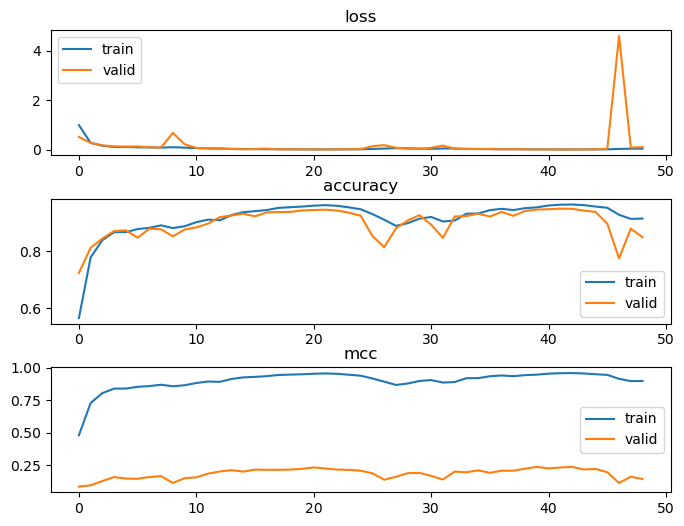

In [58]:
metric_names = ['loss', 'accuracy', 'mcc']
_, ax = plt.subplots(len(metric_names), 1, figsize=(8, 6))

for i, m in enumerate(metric_names):
    ax[i].set_title(m)
    ax[i].plot(np.array(train_metrics)[:,i], label='train')
    ax[i].plot(np.array(valid_metrics)[:,i], label='valid')
    ax[i].legend()

plt.subplots_adjust(wspace=0., hspace=0.35)
plt.show()

In [62]:
MODEL_PATH = 'trained_models\pointnet_model_best_mcc_0.2364_epoch40.pth'

classifier = pointNetModel.PointNetClassHead(num_points=NUM_TEST_POINTS, num_global_feats=GLOBAL_FEATS, k=NUM_CLASSES).to(DEVICE)
classifier.load_state_dict(torch.load(MODEL_PATH))
classifier.eval();

In [66]:
num_test_batch = int(np.ceil(len(test_dataset)/BATCH_SIZE))

with torch.no_grad():
    epoch_loss, \
    epoch_accuracy, \
    epoch_mcc, \
    total_test_targets, \
    total_test_preds = train_test(classifier, test_dataloader, 
                              num_test_batch, epoch=1, 
                              split='test')

	 [1: 0/45] test loss: 0.0549 accuracy: 0.8906 mcc: 0.0000
Epoch: 1 - test Loss: 0.1868 - test Accuracy: 0.8628 - test MCC: 0.1288


In [67]:
print(f'Test Loss: {epoch_loss:.4f} ' \
      f'- Test Accuracy: {epoch_accuracy:.4f} ' \
      f'- Test MCC: {epoch_mcc:.4f}')

Test Loss: 0.1868 - Test Accuracy: 0.8628 - Test MCC: 0.1288


In [63]:
# test Dataset  (segmentation version for display)
test_sample_dataset = ShapenetDataset(ROOT, npoints=NUM_TEST_POINTS, split='test', 
                                      classification=False, normalize=False)

In [118]:
from random import randrange

torch.cuda.empty_cache() # release GPU memory

# get random sample from test data 
random_idx = randrange(len(test_sample_dataset))
points, seg = test_sample_dataset.__getitem__(random_idx)

# normalize points
norm_points = test_sample_dataset.normalize_points(points)

with torch.no_grad():
    norm_points = norm_points.unsqueeze(0).transpose(2, 1).to(DEVICE)
    targets = targets.squeeze().to(DEVICE)

    preds, crit_idxs, _ = classifier(norm_points)
    preds = torch.softmax(preds, dim=1)
    pred_choice = preds.squeeze().argmax() 

In [119]:
pred_class = list(CATEGORIES.keys())[pred_choice.cpu().numpy()]
pred_prob = preds[0, pred_choice]
print(f'The predicted class is: {pred_class}, with probability: {pred_prob}')

The predicted class is: Airplane, with probability: 0.9969878792762756


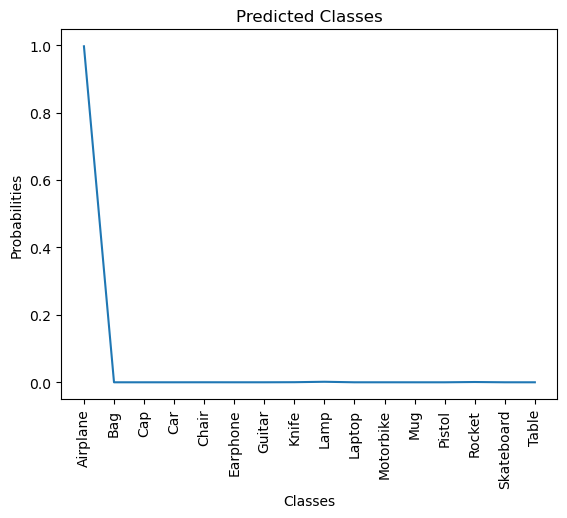

In [120]:
plt.plot(list(CATEGORIES.values()), preds.cpu().numpy()[0]);
plt.xticks(list(CATEGORIES.values()), list(CATEGORIES.keys()), rotation=90)
plt.title('Predicted Classes')
plt.xlabel('Classes')
plt.ylabel('Probabilities');

In [121]:
pointNetModel.show_3d_visualization(test_sample_dataset.__getitem__(random_idx))

In [122]:
critical_data = [test_sample_dataset.__getitem__(random_idx)[0][crit_idxs.squeeze(), :], test_sample_dataset.__getitem__(random_idx)[1]]
pointNetModel.show_3d_visualization(critical_data)